## Import Libraries

In [23]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import imgaug

from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn import visualize

import matplotlib.pyplot as plt

from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
mAP = [0.889, 0.895]

In [24]:
%matplotlib inline

## Stage-1

## Train - Test Split

In [7]:
class DamageDataset(Dataset):

    def load_dataset(self, dataset_dir, is_train=True):

        self.add_class("dataset", 1, "Damage")

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        for filename in listdir(images_dir):

            image_id = filename[:-4]

            if is_train and int(image_id) >= 420 :
                continue
            
            if not is_train and int(image_id) < 420:
                continue
            
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    
    def extract_boxes(self, filename):

        tree = ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):

        info = self.image_info[image_id]

        path = info['annotation']

        boxes, w, h = self.extract_boxes(path)

        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('Damage'))
        return masks, asarray(class_ids, dtype='int32')


    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# train set
train_set = DamageDataset()
train_set.load_dataset('customImages/stage-1', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = DamageDataset()
test_set.load_dataset('customImages/stage-1', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 391
Test: 169


# Test DamageDataset Object

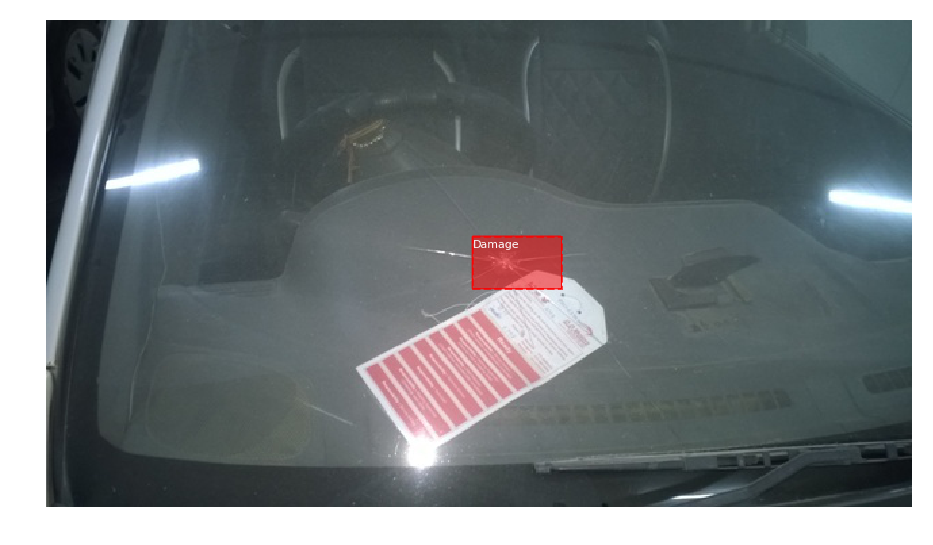

In [8]:
class DamageDataset(Dataset):

    def load_dataset(self, dataset_dir, is_train=True):

        self.add_class("dataset", 1, "Damage")

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        for filename in listdir(images_dir):

            image_id = filename[:-4]

            if is_train and int(image_id) >= 420 :
                continue
            
            if not is_train and int(image_id) < 420:
                continue
            
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    
    def extract_boxes(self, filename):

        tree = ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):

        info = self.image_info[image_id]

        path = info['annotation']

        boxes, w, h = self.extract_boxes(path)

        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('Damage'))
        return masks, asarray(class_ids, dtype='int32')


    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

train_set = DamageDataset()
train_set.load_dataset('customImages/stage-1', is_train=True)
train_set.prepare()

image_id = 0

image = train_set.load_image(image_id)

mask, class_ids = train_set.load_mask(image_id)

bbox = extract_bboxes(mask)

display_instances(image, bbox, mask, class_ids, train_set.class_names)

## Analysing Model

In [20]:
class DamageDataset(Dataset):

    def load_dataset(self, dataset_dir, is_train=True):

        self.add_class("dataset", 1, "Damage")

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        for filename in listdir(images_dir):

            image_id = filename[:-4]

            if is_train and int(image_id) >= 420 :
                continue
            
            if not is_train and int(image_id) < 420:
                continue
            
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    
    def extract_boxes(self, filename):

        tree = ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):

        info = self.image_info[image_id]

        path = info['annotation']

        boxes, w, h = self.extract_boxes(path)

        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('Damage'))
        return masks, asarray(class_ids, dtype='int32')


    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

class DamageConfig(Config):
    NAME = "damage_cfg"
    NUM_CLASSES = 1 + 1
    STEPS_PER_EPOCH = 361
    DETECTION_MIN_CONFIDENCE = 0.9

# prepare train set
train_set = DamageDataset()
train_set.load_dataset('customImages/stage-1', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# prepare test/val set
test_set = DamageDataset()
test_set.load_dataset('customImages/stage-1', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

# prepare config
config = DamageConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

Train: 391
Test: 169

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 1

## Model Training

In [21]:
class DamageDataset(Dataset):

    def load_dataset(self, dataset_dir, is_train=True):

        self.add_class("dataset", 1, "Damage")

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        for filename in listdir(images_dir):

            image_id = filename[:-4]

            if is_train and int(image_id) >= 420 :
                continue
            
            if not is_train and int(image_id) < 420:
                continue
            
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    
    def extract_boxes(self, filename):

        tree = ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):

        info = self.image_info[image_id]

        path = info['annotation']

        boxes, w, h = self.extract_boxes(path)

        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('Damage'))
        return masks, asarray(class_ids, dtype='int32')


    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

class DamageConfig(Config):
    NAME = "damage_cfg"
    NUM_CLASSES = 1 + 1
    STEPS_PER_EPOCH = 361
    DETECTION_MIN_CONFIDENCE = 0.9

# prepare train set
train_set = DamageDataset()
train_set.load_dataset('customImages/stage-1', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# prepare test/val set
test_set = DamageDataset()
test_set.load_dataset('customImages/stage-1', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

# prepare config
config = DamageConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')

Train: 391
Test: 169

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 1

C:\Users\Eashan\Anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Eashan\Anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Eashan\Anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 1/5


KeyboardInterrupt: 

## Model Evaluate

In [42]:
class DamageDataset(Dataset):

    def load_dataset(self, dataset_dir, is_train=True):

        self.add_class("dataset", 1, "Damage")

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        for filename in listdir(images_dir):

            image_id = filename[:-4]

            if is_train and int(image_id) >= 160 :
                continue
            
            if not is_train and int(image_id) < 160:
                continue
            
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    
    def extract_boxes(self, filename):

        tree = ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):

        info = self.image_info[image_id]

        path = info['annotation']

        boxes, w, h = self.extract_boxes(path)

        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('Damage'))
        return masks, asarray(class_ids, dtype='int32')


    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

class PredictionConfig(Config):
    NAME = "damage_cfg"
    NUM_CLASSES = 1 + 1
    STEPS_PER_EPOCH = 361
    DETECTION_MIN_CONFIDENCE = 0.95
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:

        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)

        scaled_image = mold_image(image, cfg)

        sample = expand_dims(scaled_image, 0)

        yhat = model.detect(sample, verbose=0)

        r = yhat[0]

        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])

        APs.append(AP)
    mAP = mean(APs)
    return mAP

# load the train dataset
train_set = DamageDataset()
train_set.load_dataset('customImages/stage-2', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# load the test dataset
test_set = DamageDataset()
test_set.load_dataset('customImages/stage-2', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('damage_cfg20210205/mask_rcnn_damage_cfg_0005.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Train: 159
Test: 26


D:\Users\Eashan\Desktop\Damage Detection\mrcnn\utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)
D:\Users\Eashan\Desktop\Damage Detection\mrcnn\utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)


Train mAP: nan
Test mAP: 0.000


## Single Prediction

In [5]:
class DamageDataset(Dataset):

    def load_dataset(self, dataset_dir, is_train=True):

        self.add_class("dataset", 1, "Damage")

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        for filename in listdir(images_dir):

            image_id = filename[:-4]

            if is_train and int(image_id) >= 420 :
                continue
            
            if not is_train and int(image_id) < 420:
                continue
            
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    
    def extract_boxes(self, filename):

        tree = ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):

        info = self.image_info[image_id]

        path = info['annotation']

        boxes, w, h = self.extract_boxes(path)

        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('Damage'))
        return masks, asarray(class_ids, dtype='int32')


    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

class PredictionConfig(Config):
    NAME = "damage_cfg"
    NUM_CLASSES = 1 + 1
    DETECTION_MIN_CONFIDENCE = 0.95
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model_path = 'damage_cfg20210203/mask_rcnn_damage_cfg_0005.h5'
model.load_weights(model_path, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.








Processing 1 images
image                    shape: (768, 1024, 3)        min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


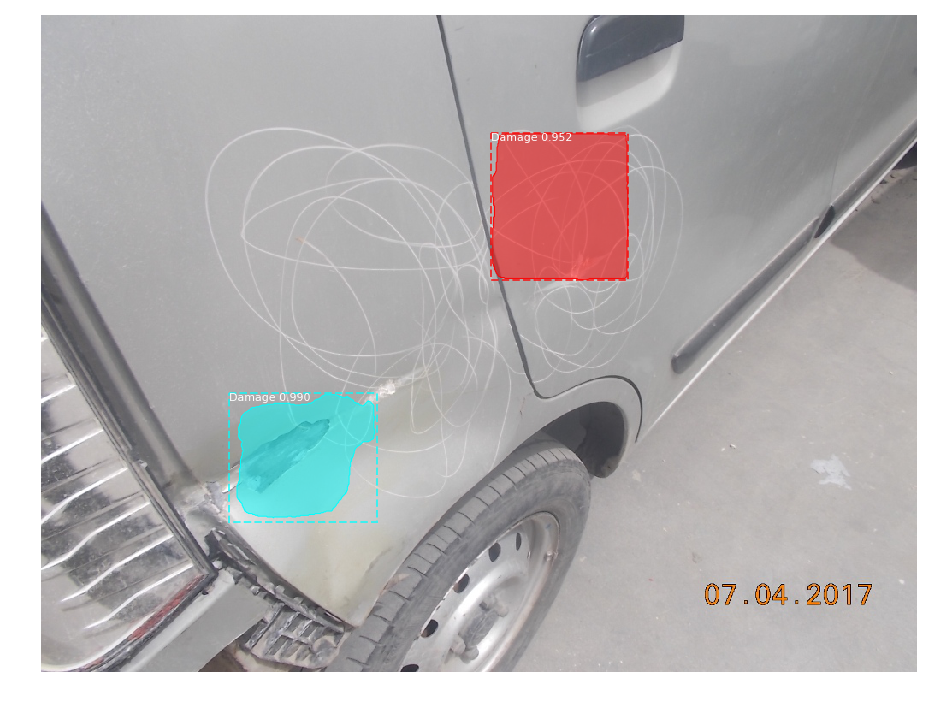

In [20]:
image = load_img("customImages/stage-1/images/416.jpg")
image = img_to_array(image)
results = model.detect([image], verbose=1)
class_names = ['BG', 'Damage']
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names,  r['scores'])

## Stage-2

## Train Test Split

In [3]:
class DamageDataset(Dataset):

    def load_dataset(self, dataset_dir, is_train=True):

        self.add_class("dataset", 1, "Level-1")
        self.add_class("dataset", 1, "Level-2")
        self.add_class("dataset", 1, "Level-3")
        self.add_class("dataset", 1, "Level-4")

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        for filename in listdir(images_dir):

            image_id = filename[:-4]

            if is_train and int(image_id) >= 160 :
                continue
            
            if not is_train and int(image_id) < 160:
                continue
            
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    
    def extract_boxes(self, filename):

        tree = ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//bndbox'):
            name = box.find('name').text
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax, name]
            if name=='Level-1' or name=='Level-2' or name=='Level-3' or name=='Level-4':
                boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):

        info = self.image_info[image_id]

        path = info['annotation']

        boxes, w, h = self.extract_boxes(path)

        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            if (box[4] == 'Level-1'):
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('Level-1'))
            elif(box[4] == 'Level-2'):
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('Level-2')) 
            elif(box[4] == 'Level-3'):
                masks[row_s:row_e, col_s:col_e, i] = 3
                class_ids.append(self.class_names.index('Level-3'))
            else:
                masks[row_s:row_e, col_s:col_e, i] = 4
                class_ids.append(self.class_names.index('Level-4'))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# train set
train_set = DamageDataset()
train_set.load_dataset('customImages/stage-2', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = DamageDataset()
test_set.load_dataset('customImages/stage-2', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 159
Test: 26


## Model Summary

In [2]:
from keras.utils.vis_utils import plot_model

In [3]:
class DamageDataset(Dataset):

    def load_dataset(self, dataset_dir, is_train=True):

        self.add_class("dataset", 1, "Level-1")
        self.add_class("dataset", 2, "Level-2")
        self.add_class("dataset", 3, "Level-3")
        self.add_class("dataset", 4, "Level-4")

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        for filename in listdir(images_dir):

            image_id = filename[:-4]

            if is_train and int(image_id) >= 160 :
                continue
            
            if not is_train and int(image_id) < 160:
                continue
            
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    
    def extract_boxes(self, filename):

        tree = ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//object'):
            name = box.find('name').text
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin, ymin, xmax, ymax, name]
            if name=='Level-1' or name=='Level-2' or name=='Level-3' or name=='Level-4':
                boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):

        info = self.image_info[image_id]

        path = info['annotation']

        boxes, w, h = self.extract_boxes(path)

        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            if (box[4] == 'Level-1'):
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('Level-1'))
            elif(box[4] == 'Level-2'):
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('Level-2')) 
            elif(box[4] == 'Level-3'):
                masks[row_s:row_e, col_s:col_e, i] = 3
                class_ids.append(self.class_names.index('Level-3'))
            else:
                masks[row_s:row_e, col_s:col_e, i] = 4
                class_ids.append(self.class_names.index('Level-4'))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

class DamageConfig(Config):
    NAME = "damage_cfg"
    NUM_CLASSES = 1 + 4
    STEPS_PER_EPOCH = 160
    DETECTION_MIN_CONFIDENCE = 0.9
    
config = DamageConfig()
model = MaskRCNN(mode='inference', model_dir='./', config=config)
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
print(model.keras_model.summary())








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.






Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
_______________________________________________________

## Model Training

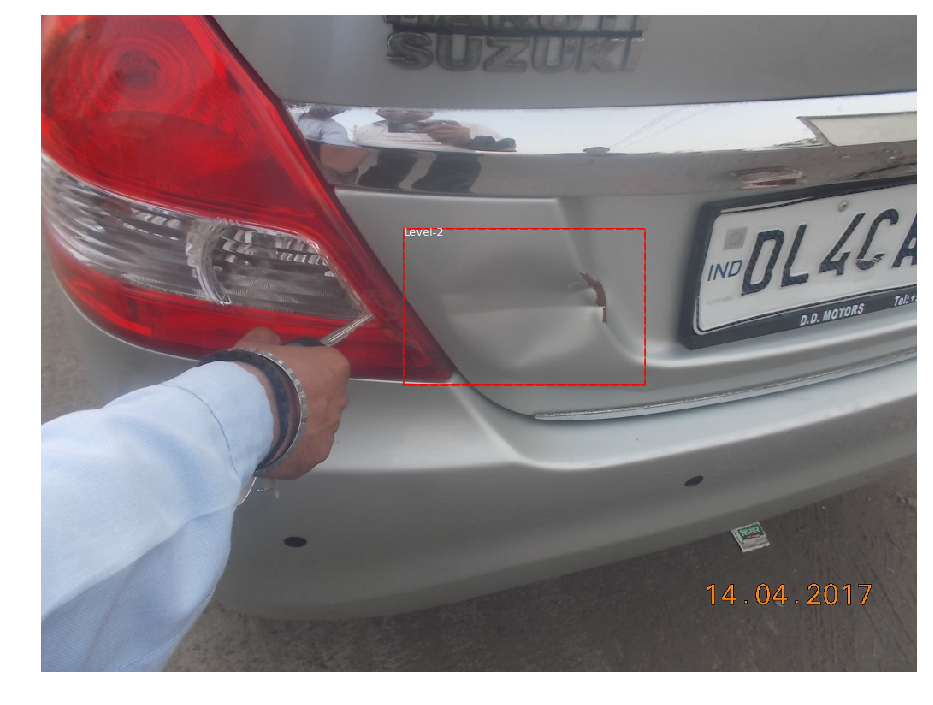

In [55]:
class DamageDataset(Dataset):

    def load_dataset(self, dataset_dir, is_train=True):

        self.add_class("dataset", 1, "Level-1")
        self.add_class("dataset", 2, "Level-2")
        self.add_class("dataset", 3, "Level-3")
        self.add_class("dataset", 4, "Level-4")

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        for filename in listdir(images_dir):

            image_id = filename[:-4]

            if is_train and int(image_id) >= 160 :
                continue
            
            if not is_train and int(image_id) < 160:
                continue
            
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    
    def extract_boxes(self, filename):

        tree = ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//object'):
            name = box.find('name').text
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin, ymin, xmax, ymax, name]
            if name=='Level-1' or name=='Level-2' or name=='Level-3' or name=='Level-4':
                boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):

        info = self.image_info[image_id]

        path = info['annotation']

        boxes, w, h = self.extract_boxes(path)

        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            if (box[4] == 'Level-1'):
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('Level-1'))
            elif(box[4] == 'Level-2'):
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('Level-2')) 
            elif(box[4] == 'Level-3'):
                masks[row_s:row_e, col_s:col_e, i] = 3
                class_ids.append(self.class_names.index('Level-3'))
            else:
                masks[row_s:row_e, col_s:col_e, i] = 4
                class_ids.append(self.class_names.index('Level-4'))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

train_set = DamageDataset()
train_set.load_dataset('customImages/stage-2/', is_train=True)
train_set.prepare()

image_id = 0

image = train_set.load_image(image_id)

mask, class_ids = train_set.load_mask(image_id)

bbox = extract_bboxes(mask)

display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [26]:
class DamageDataset(Dataset):

    def load_dataset(self, dataset_dir, is_train=True):

        self.add_class("dataset", 1, "Level-1")
        self.add_class("dataset", 2, "Level-2")
        self.add_class("dataset", 3, "Level-3")
        self.add_class("dataset", 4, "Level-4")

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        for filename in listdir(images_dir):

            image_id = filename[:-4]

            if is_train and int(image_id) >= 160 :
                continue
            
            if not is_train and int(image_id) < 160:
                continue
            
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    
    def extract_boxes(self, filename):

        tree = ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//object'):
            name = box.find('name').text
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin, ymin, xmax, ymax, name]
            if name=='Level-1' or name=='Level-2' or name=='Level-3' or name=='Level-4':
                boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):

        info = self.image_info[image_id]

        path = info['annotation']

        boxes, w, h = self.extract_boxes(path)

        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            if (box[4] == 'Level-1'):
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('Level-1'))
            elif(box[4] == 'Level-2'):
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('Level-2')) 
            elif(box[4] == 'Level-3'):
                masks[row_s:row_e, col_s:col_e, i] = 3
                class_ids.append(self.class_names.index('Level-3'))
            else:
                masks[row_s:row_e, col_s:col_e, i] = 4
                class_ids.append(self.class_names.index('Level-4'))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

class DamageConfig(Config):
    NAME = "damage_cfg"
    NUM_CLASSES = 1 + 4
    STEPS_PER_EPOCH = 160
    DETECTION_MIN_CONFIDENCE = 0.9
    

# prepare train set
train_set = DamageDataset()
train_set.load_dataset('customImages/stage-2', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# prepare test/val set
test_set = DamageDataset()
test_set.load_dataset('customImages/stage-2', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

# prepare config
config = DamageConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_damage_cfg_20210205.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])

model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')

Train: 159
Test: 26

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14

C:\Users\Eashan\Anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Eashan\Anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Eashan\Anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 1/5


KeyboardInterrupt: 

## Single Prediction

In [52]:
class DamageDataset(Dataset):

    def load_dataset(self, dataset_dir, is_train=True):

        self.add_class("dataset", 1, "Level-1")
        self.add_class("dataset", 2, "Level-2")
        self.add_class("dataset", 3, "Level-3")
        self.add_class("dataset", 4, "Level-4")

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        for filename in listdir(images_dir):

            image_id = filename[:-4]

            if is_train and int(image_id) >= 160 :
                continue
            
            if not is_train and int(image_id) < 160:
                continue
            
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    
    def extract_boxes(self, filename):

        tree = ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//object'):
            name = box.find('name').text
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin, ymin, xmax, ymax, name]
            if name=='Level-1' or name=='Level-2' or name=='Level-3' or name=='Level-4':
                boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):

        info = self.image_info[image_id]

        path = info['annotation']

        boxes, w, h = self.extract_boxes(path)

        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            if (box[4] == 'Level-1'):
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('Level-1'))
            elif(box[4] == 'Level-2'):
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('Level-2')) 
            elif(box[4] == 'Level-3'):
                masks[row_s:row_e, col_s:col_e, i] = 3
                class_ids.append(self.class_names.index('Level-3'))
            else:
                masks[row_s:row_e, col_s:col_e, i] = 4
                class_ids.append(self.class_names.index('Level-4'))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

class PredictionConfig(Config):
    NAME = "damage_cfg"
    NUM_CLASSES = 1 + 4
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model_path = 'damage_cfg20210301/mask_rcnn_damage_cfg_0005.h5'
model.load_weights(model_path, by_name=True)

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



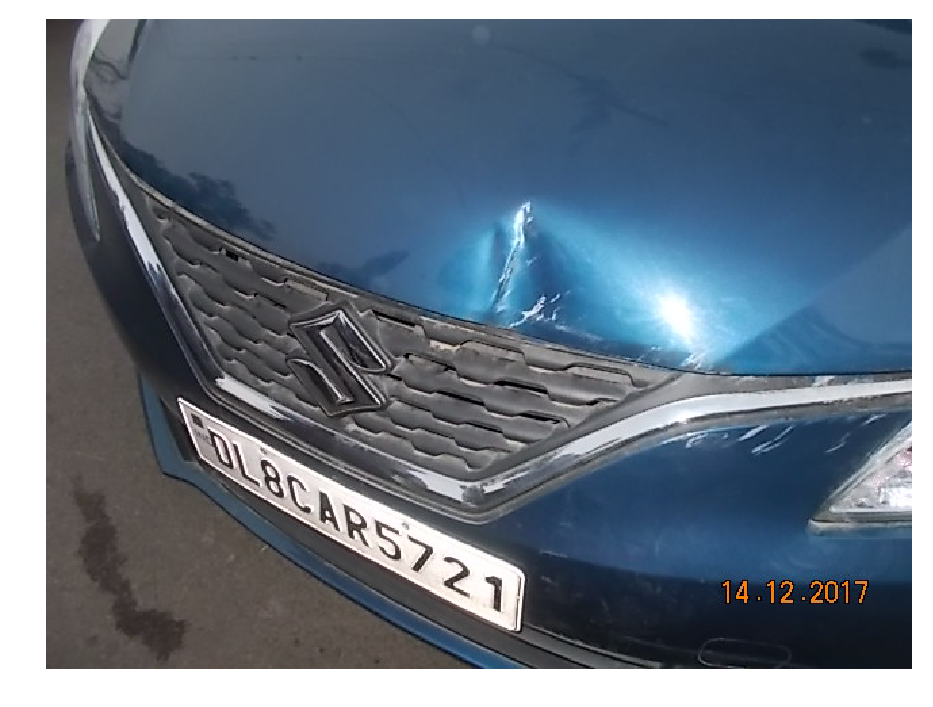

In [53]:
image = load_img("customImages/stage-2/images/126.jpg")
image = img_to_array(image)
results = model.detect([image], verbose=1)
class_names = ['BG', 'Level-1', 'Level-2', 'Level-3', 'Level-4']
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names,  r['scores'])

## Model Evaluation

In [ ]:
class DamageDataset(Dataset):

    def load_dataset(self, dataset_dir, is_train=True):

        self.add_class("dataset", 1, "Level-1")
        self.add_class("dataset", 1, "Level-2")
        self.add_class("dataset", 1, "Level-3")
        self.add_class("dataset", 1, "Level-4")

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        for filename in listdir(images_dir):

            image_id = filename[:-4]

            if is_train and int(image_id) >= 160 :
                continue
            
            if not is_train and int(image_id) < 160:
                continue
            
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    
    def extract_boxes(self, filename):

        tree = ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//bndbox'):
            name = box.find('name').text
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax, name]
            if name=='Level-1' or name=='Level-2' or name=='Level-3' or name=='Level-4':
                boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):

        info = self.image_info[image_id]

        path = info['annotation']

        boxes, w, h = self.extract_boxes(path)

        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            if (box[4] == 'Level-1'):
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('Level-1'))
            elif(box[4] == 'Level-2'):
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('Level-2')) 
            elif(box[4] == 'Level-3'):
                masks[row_s:row_e, col_s:col_e, i] = 3
                class_ids.append(self.class_names.index('Level-3'))
            else:
                masks[row_s:row_e, col_s:col_e, i] = 4
                class_ids.append(self.class_names.index('Level-4'))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

class PredictionConfig(Config):
    NAME = "damage_cfg"
    NUM_CLASSES = 1 + 4
    DETECTION_MIN_CONFIDENCE = 0.95
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:

        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)

        scaled_image = mold_image(image, cfg)

        sample = expand_dims(scaled_image, 0)

        yhat = model.detect(sample, verbose=0)

        r = yhat[0]

        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])

        APs.append(AP)
    mAP = mean(APs)
    return mAP

# load the train dataset
train_set = DamageDataset()
train_set.load_dataset('customImages/stage-2', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# load the test dataset
test_set = DamageDataset()
test_set.load_dataset('customImages/stage-2', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('damage_cfg20210203/mask_rcnn_damage_cfg_0005.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

## Stage 3

## Model Training

In [3]:
class DamageDataset(Dataset):

    def load_dataset(self, dataset_dir, subset):

        self.add_class("damage", 1, "Scratch")
        self.add_class("damage", 2, "Dent")
        self.add_class("damage", 3, "Shatter")
        self.add_class("damage", 4, "Dislocation")
        
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }

        annotations1 = json.load(open(os.path.join(dataset_dir, "via_project.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  

        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['damage'] for s in a['regions']]
            name_dict = {"Scratch": 1, "Dent": 2, "Shatter": 3, "Dislocation": 4}
            
            num_ids = [name_dict[a] for a in objects]

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "damage",
                image_id=a['filename'],
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        
        image_info = self.image_info[image_id]
        if image_info["source"] != "damage":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "damage":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

            mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "damage":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

# define a configuration for the model
class DamageConfig(Config):
    # define the name of the configuration
    NAME = "damage"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 4
    # number of training steps per epoch
    STEPS_PER_EPOCH = 160
    LEARNING_RATE=0.002
    Train_ROIs_Per_Image=200
    RPN_ANCHOR_SCALES=(16, 32, 48, 64, 128)

In [4]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = DamageDataset()
    dataset_train.load_dataset("customImages/stage-3", "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = DamageDataset()
    dataset_val.load_dataset("customImages/stage-3", "val")
    dataset_val.prepare()

    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=15,
                layers='heads',
                )

In [5]:
config = DamageConfig()
model = MaskRCNN(mode="training", config=config,model_dir='./')

weights_path = 'damage20210322T1115/mask_rcnn_damage_0011.h5'

model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [6]:
train(model)

numids [4, 2]
numids [4]
numids [4]
numids [4, 2]
numids [4]
numids [2]
numids [4, 1]
numids [3]
numids [4, 1]
numids [4]
numids [4]
numids [4]
numids [2]
numids [4]
numids [4]
numids [4, 2]
numids [4]
numids [3, 3]
numids [1]
numids [4, 2]
numids [4]
numids [4]
numids [4]
numids [4]
numids [4]
numids [2]
numids [4]
numids [4]
numids [4]
numids [1]
numids [4]
numids [4]
numids [4]
numids [4]
numids [1]
numids [1]
numids [1]
numids [2]
numids [1, 1]
numids [1]
numids [3, 3]
numids [1]
numids [1]
numids [1]
numids [1]
numids [1]
numids [3, 3]
numids [1]
numids [1]
numids [4]
numids [1]
numids [4]
numids [4]
numids [2]
numids [2]
numids [2]
numids [1]
numids [2]
numids [2, 1]
numids [2]
numids [2]
numids [2, 4]
numids [1]
numids [2]
numids [2, 4]
numids [2, 2]
numids [1]
numids [2, 2]
numids [2, 2]
numids [2, 4]
numids [1]
numids [2]
numids [1, 1]
numids [1]
numids [1]
numids [2, 2, 1, 1, 1, 1]
numids [1]
numids [1]
numids [1]
numids [1, 1]
numids [1, 1]
numids [1]
numids [1]
numids [1]
n

C:\Users\Eashan\Anaconda3\envs\mask_rcnn\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



Starting at epoch 0. LR=0.002

Checkpoint Path: ./damage20210415T1409\mask_rcnn_damage_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistrib

C:\Users\Eashan\Anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Eashan\Anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Eashan\Anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 1/15
160/160 [==============================] - 13575s 85s/step - loss: 1.5206 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.6158 - mrcnn_class_loss: 0.1252 - mrcnn_bbox_loss: 0.5020 - mrcnn_mask_loss: 0.2691 - val_loss: 3.7493 - val_rpn_class_loss: 0.0238 - val_rpn_bbox_loss: 2.6524 - val_mrcnn_class_loss: 0.1028 - val_mrcnn_bbox_loss: 0.5029 - val_mrcnn_mask_loss: 0.4674

Epoch 2/15
160/160 [==============================] - 13768s 86s/step - loss: 1.2998 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.7061 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.2994 - mrcnn_mask_loss: 0.2203 - val_loss: 3.7649 - val_rpn_class_loss: 0.0232 - val_rpn_bbox_loss: 2.7941 - val_mrcnn_class_loss: 0.0665 - val_mrcnn_bbox_loss: 0.4551 - val_mrcnn_mask_loss: 0.4260
Epoch 3/15
160/160 [==============================] - 13890s 87s/step - loss: 1.1441 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.6592 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.2309 - mrcnn_mask_loss: 0.1953 - val_loss: 3.7265 - v

KeyboardInterrupt: 

## Model Evaluation

In [20]:
class DamageDataset(Dataset):

    def load_dataset(self, dataset_dir, subset):

        self.add_class("damage", 1, "Scratch")
        self.add_class("damage", 2, "Dent")
        self.add_class("damage", 3, "Shatter")
        self.add_class("damage", 4, "Dislocation")
        
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }

        annotations1 = json.load(open(os.path.join(dataset_dir, "via_project.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  

        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['damage'] for s in a['regions']]
            name_dict = {"Scratch": 1, "Dent": 2, "Shatter": 3, "Dislocation": 4}
            
            num_ids = [name_dict[a] for a in objects]

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "damage",
                image_id=a['filename'],
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        
        image_info = self.image_info[image_id]
        if image_info["source"] != "damage":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "damage":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

            mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "damage":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

class PredictionConfig(Config):
    NAME = "damage"
    NUM_CLASSES = 1 + 4
    DETECTION_MIN_CONFIDENCE = 0.85
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:

        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)

        scaled_image = mold_image(image, cfg)

        sample = expand_dims(scaled_image, 0)

        yhat = model.detect(sample, verbose=0)

        r = yhat[0]

        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])

        APs.append(AP)
    maP = mean(APs)
    return mAP


train_set = DamageDataset()
train_set.load_dataset("customImages/stage-3", "train")
train_set.prepare()

    # Validation dataset
test_set = DamageDataset()
test_set.load_dataset("customImages/stage-3", "val")
test_set.prepare()

# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('damage20210322T1115/mask_rcnn_damage_0011.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP[0])
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP[1])

Train mAP: 0.889
Test mAP: 0.895


## Single Prediction

In [25]:
class DamageDataset(Dataset):

    def load_dataset(self, dataset_dir, subset):

        self.add_class("damage", 1, "Scratch")
        self.add_class("damage", 2, "Dent")
        self.add_class("damage", 3, "Shatter")
        self.add_class("damage", 4, "Dislocation")
        
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }

        annotations1 = json.load(open(os.path.join(dataset_dir, "via_project.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  

        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['damage'] for s in a['regions']]
            name_dict = {"Scratch": 1, "Dent": 2, "Shatter": 3, "Dislocation": 4}
            
            num_ids = [name_dict[a] for a in objects]

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "damage",
                image_id=a['filename'],
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        
        image_info = self.image_info[image_id]
        if image_info["source"] != "damage":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "damage":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

            mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "damage":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
# define a configuration for the model
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "damage"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 4
    # number of training steps per epoch
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [26]:
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model_path = 'damage20210322T1115/mask_rcnn_damage_0011.h5'
model.load_weights(model_path, by_name=True)

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


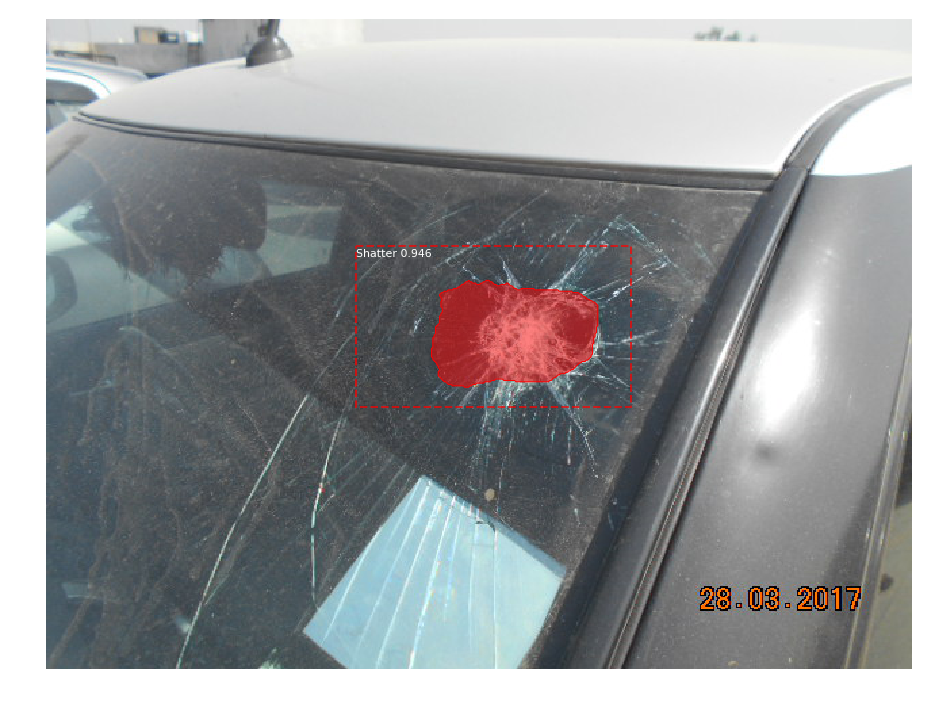

In [7]:
image = load_img("customImages/stage-3/train/117.jpg")
image = img_to_array(image)
results = model.detect([image], verbose=1)
class_names = ['BG', 'Scratch', 'Dent', 'Shatter', 'Dislocation']
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names,  r['scores'])

# METRICS

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

logs = pd.read_csv('logs.csv')
prediction_summary = pd.read_csv('prediction_summary-1.csv')

In [15]:
loss = logs.loss
val_loss = logs.val_loss

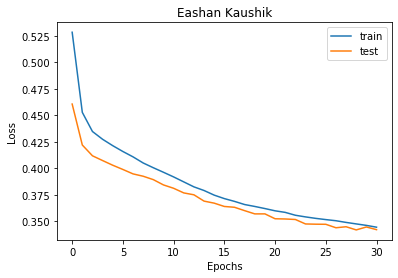

In [16]:
plt.plot(loss, label='train')
plt.plot(val_loss, label='test')
plt.legend()
plt.title('Eashan Kaushik')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.show()
# plt.savefig('logs.png')

In [19]:
y_test = prediction_summary.y_test
y_pred = prediction_summary.y_pred
y_prob = prediction_summary.y_prob

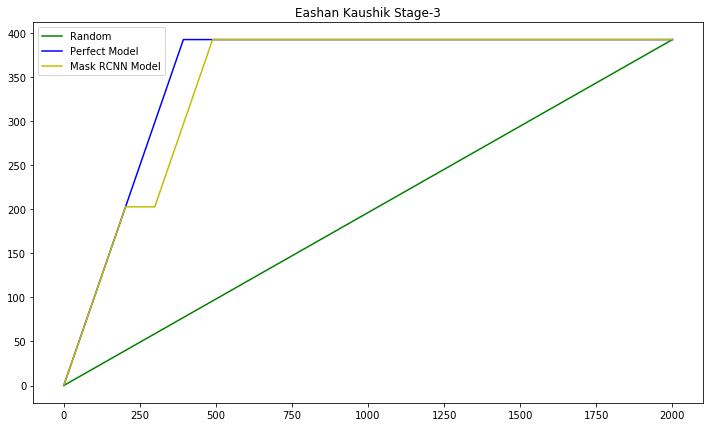

In [20]:
total = len(y_test)
one_count = np.sum(y_test)
zero_count = total - one_count

y_sort = [y for _, y in sorted(zip(y_pred, y_test), reverse=True)]

x = np.arange(0, total+1)

y_plot = np.append([0], np.cumsum(y_sort))

plt.figure(figsize=(12,7))
plt.plot([0, total], [0, one_count], 'g', label='Random')
plt.plot([0, one_count, total], [0, one_count, one_count], 'b', label='Perfect Model')
plt.plot(x, y_plot, 'y', label='Mask RCNN Model')
plt.legend()
plt.title('Eashan Kaushik Stage-3')
plt.show()

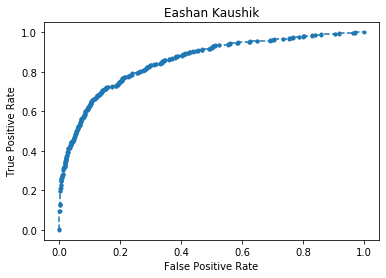

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, threshold = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, ls='--', marker='.')
plt.title('Eashan Kaushik')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
# plt.savefig('ROC-Curve.png')
plt.show()